
# EDA: Reinvestment Rate Proxy (SOFR) vs Federal Funds Rate (FEDFUNDS)

**Goal:** Understand how a reinvestment-rate proxy (SOFR) moves relative to the Federal Funds Rate (FEDFUNDS), and what this implies for building a model that maps a Fed-rate path to reinvestment rates.

**Why this matters for the project:** Reinvestment returns affect portfolio cash flows after prepayment/default; we use SOFR as a proxy for short-term reinvestment rates.





## Definitions

**Federal Funds Rate (FEDFUNDS):**
A benchmark U.S. interest rate associated with overnight lending between banks. It reflects the Fed’s policy stance and is a standard macro “base rate” for many short-term rates.

**SOFR (Secured Overnight Financing Rate):**
A broad measure of the cost of overnight borrowing collateralized by U.S. Treasury securities. It is widely used as a reference for short-term funding and is often a useful proxy for short-term reinvestment rates.

**Key practical issue for this notebook:**
FEDFUNDS is reported **monthly** (in our file), while SOFR is **daily**. We must align them to a common frequency before comparing or modeling.



In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)


## Load data
We load FEDFUNDS (monthly) and SOFR (daily), check types, missingness, and date ranges.


In [71]:
df_fed_funds = pd.read_csv("/content/sample_data/FEDFUNDS.csv")
df_sofr = pd.read_csv("/content/sample_data/SOFR.csv")

# Convert dates
df_fed_funds["observation_date"] = pd.to_datetime(df_fed_funds["observation_date"])
df_sofr["observation_date"] = pd.to_datetime(df_sofr["observation_date"])

print("FEDFUNDS shape:", df_fed_funds.shape)
print("SOFR shape:", df_sofr.shape)

print("\nMissing values:")
print("FEDFUNDS:", df_fed_funds["FEDFUNDS"].isna().sum())
print("SOFR:", df_sofr["SOFR"].isna().sum())

print("\nDate ranges:")
print("FEDFUNDS:", df_fed_funds["observation_date"].min(), "to", df_fed_funds["observation_date"].max())
print("SOFR:", df_sofr["observation_date"].min(), "to", df_sofr["observation_date"].max())


FEDFUNDS shape: (301, 2)
SOFR shape: (2023, 2)

Missing values:
FEDFUNDS: 0
SOFR: 88

Date ranges:
FEDFUNDS: 2001-01-01 00:00:00 to 2026-01-01 00:00:00
SOFR: 2018-04-03 00:00:00 to 2026-01-01 00:00:00


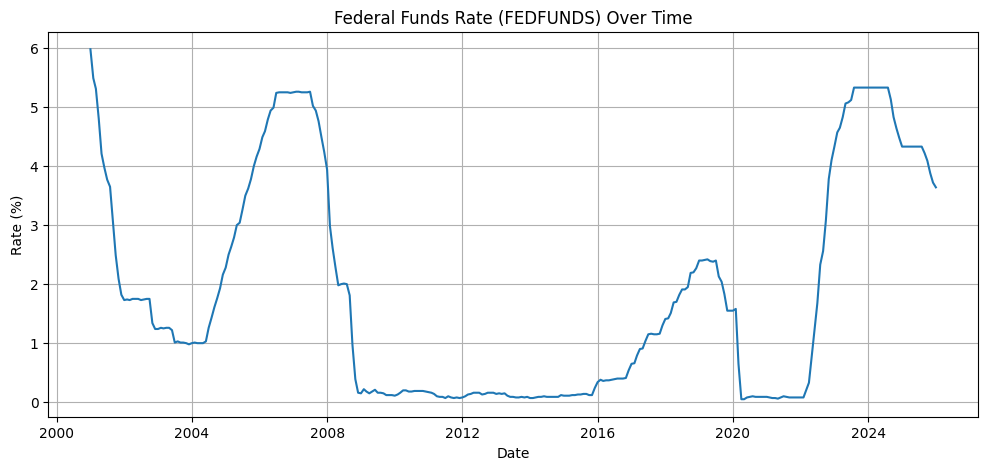

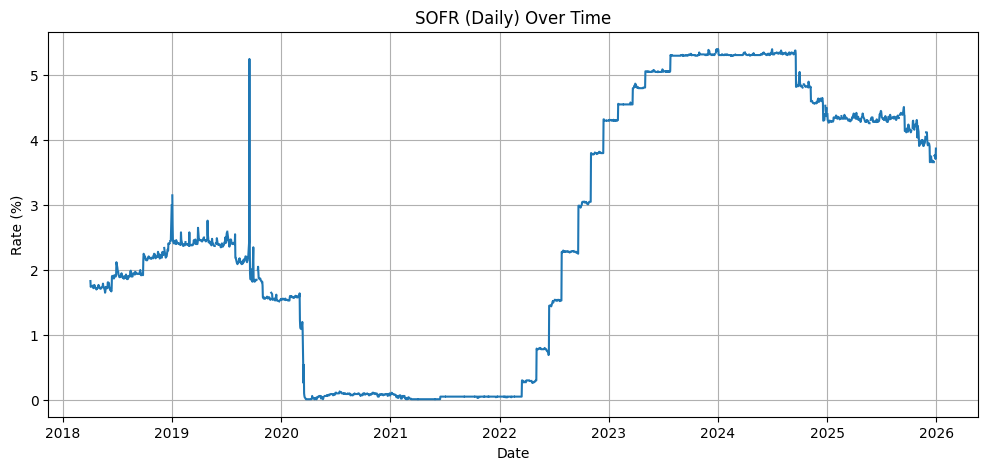

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(df_fed_funds["observation_date"], df_fed_funds["FEDFUNDS"])
plt.title("Federal Funds Rate (FEDFUNDS) Over Time")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_sofr["observation_date"], df_sofr["SOFR"])
plt.title("SOFR (Daily) Over Time")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.grid(True)
plt.show()


## Align frequencies (monthly)
Because FEDFUNDS is monthly and SOFR is daily, we resample SOFR to a **monthly** series.

We use **month-start ("MS")** to match the FEDFUNDS file's timestamps (YYYY-MM-01).



In [73]:
# Set datetime index (required for resample)
fed = df_fed_funds.set_index("observation_date").sort_index()
sofr = df_sofr.set_index("observation_date").sort_index()

# Monthly SOFR (month-start)
sofr_monthly = sofr["SOFR"].resample("MS").mean().to_frame()

# Join on aligned timestamps
df_merged = fed.join(sofr_monthly, how="inner")

print("Merged shape:", df_merged.shape)
display(df_merged.head())



Merged shape: (94, 2)


,FEDFUNDS,SOFR
observation_date,,
2018-04-01,1.69,1.742000
2018-05-01,1.70,1.730455
2018-06-01,1.82,1.836667
2018-07-01,1.91,1.913810
2018-08-01,1.91,1.917391


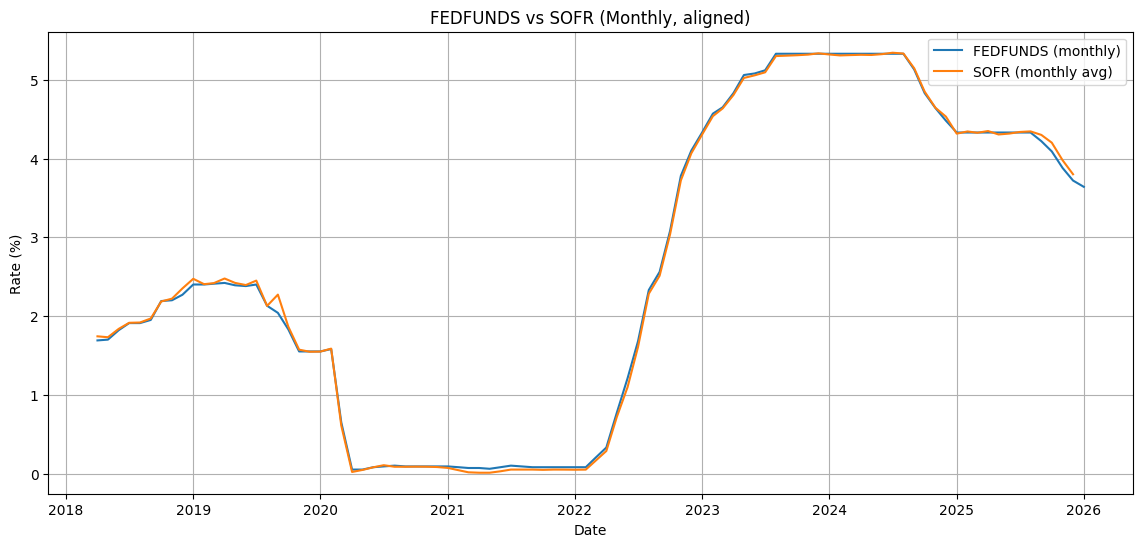

Monthly Pearson correlation: 0.9998


In [74]:
plt.figure(figsize=(14, 6))
plt.plot(df_merged.index, df_merged["FEDFUNDS"], label="FEDFUNDS (monthly)")
plt.plot(df_merged.index, df_merged["SOFR"], label="SOFR (monthly avg)")
plt.title("FEDFUNDS vs SOFR (Monthly, aligned)")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

corr = df_merged["FEDFUNDS"].corr(df_merged["SOFR"])
print(f"Monthly Pearson correlation: {corr:.4f}")



**Observation:** SOFR closely tracks FEDFUNDS at monthly frequency (correlation very close to 1).


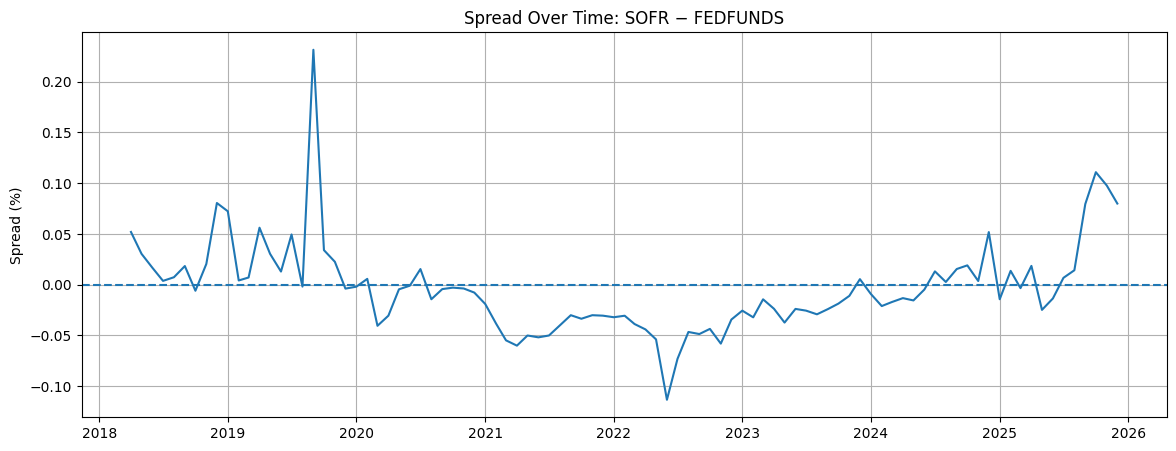

Mean spread: -0.003469296372669913
Std spread: 0.04516668678779691


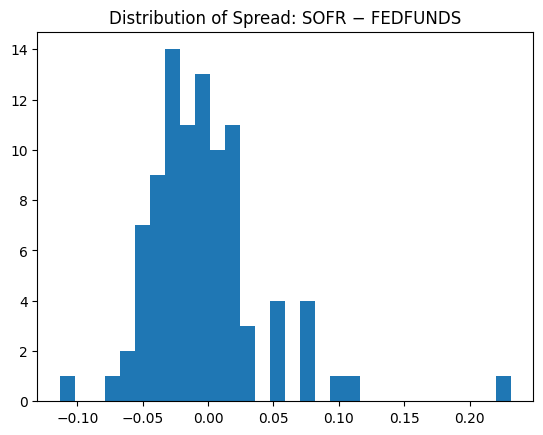

In [75]:
df_merged["spread"] = df_merged["SOFR"] - df_merged["FEDFUNDS"]

plt.figure(figsize=(14, 5))
plt.plot(df_merged.index, df_merged["spread"])
plt.axhline(0, linestyle="--")
plt.title("Spread Over Time: SOFR − FEDFUNDS")
plt.ylabel("Spread (%)")
plt.grid(True)
plt.show()

print("Mean spread:", df_merged["spread"].mean())
print("Std spread:", df_merged["spread"].std())

df_merged["spread"].hist(bins=30)
plt.title("Distribution of Spread: SOFR − FEDFUNDS")
plt.grid(False)
plt.show()




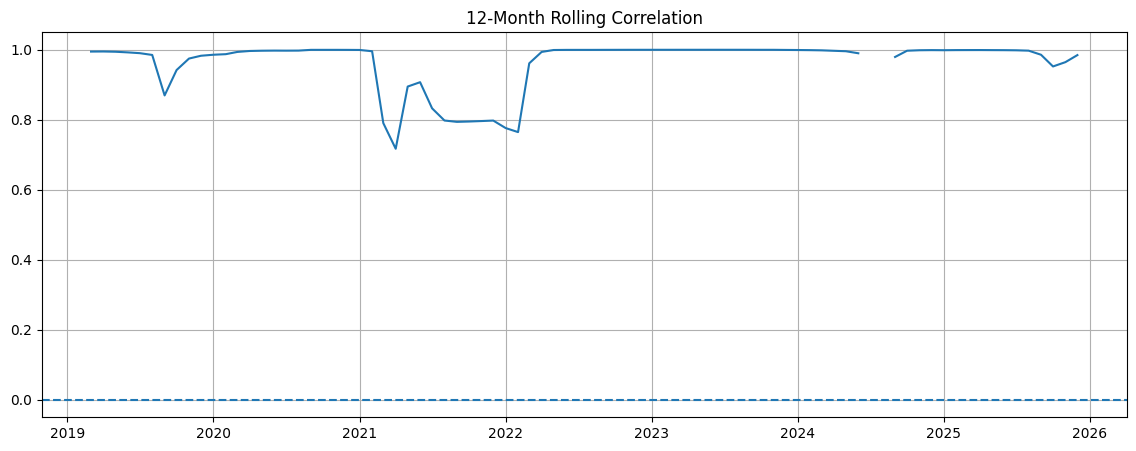

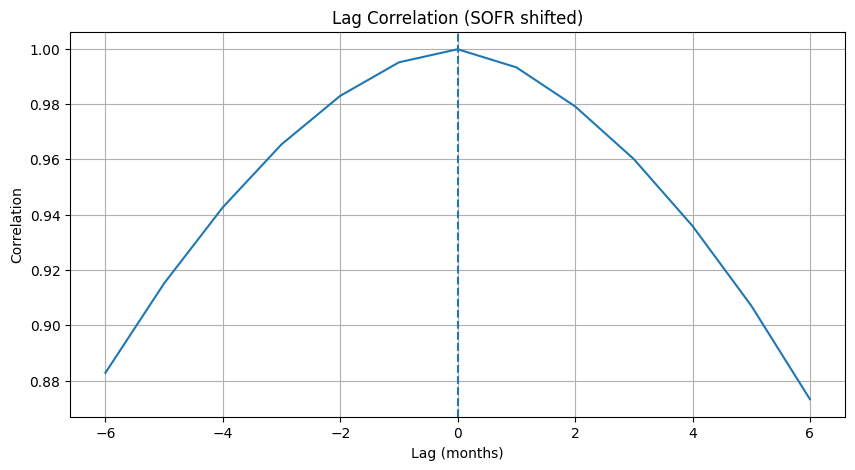

In [76]:
df_merged["rolling_corr_12m"] = (
    df_merged["FEDFUNDS"].rolling(12).corr(df_merged["SOFR"])
)

plt.figure(figsize=(14, 5))
plt.plot(df_merged.index, df_merged["rolling_corr_12m"])
plt.title("12-Month Rolling Correlation")
plt.axhline(0, linestyle="--")
plt.grid(True)
plt.show()

lags = range(-6, 7)
corrs = [df_merged["FEDFUNDS"].corr(df_merged["SOFR"].shift(lag)) for lag in lags]

plt.figure(figsize=(10, 5))
plt.plot(lags, corrs)
plt.axvline(0, linestyle="--")
plt.title("Lag Correlation (SOFR shifted)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()



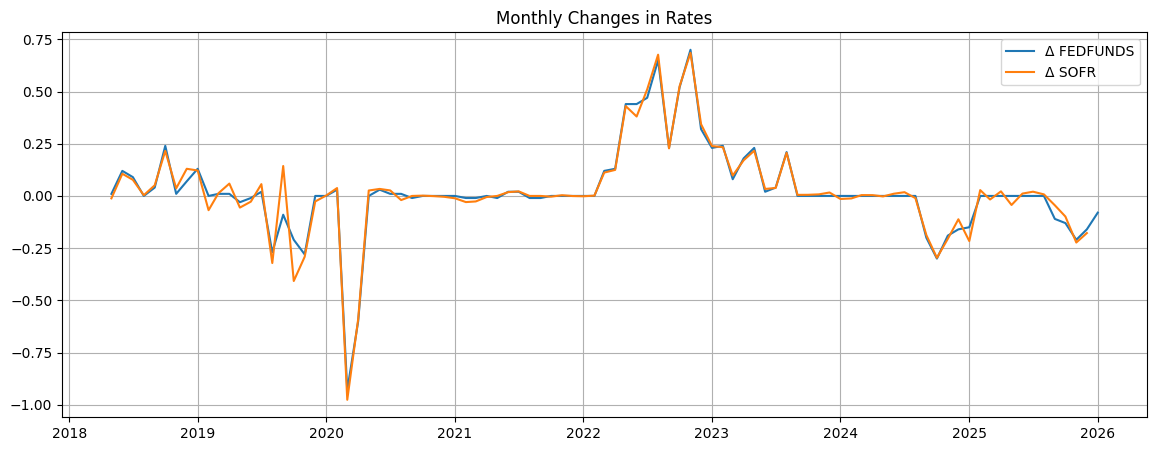

FED volatility (std of monthly change): 0.20959103301911466
SOFR volatility (std of monthly change): 0.2176055436702177


In [77]:
df_merged["FED_diff"] = df_merged["FEDFUNDS"].diff()
df_merged["SOFR_diff"] = df_merged["SOFR"].diff()

plt.figure(figsize=(14, 5))
plt.plot(df_merged.index, df_merged["FED_diff"], label="Δ FEDFUNDS")
plt.plot(df_merged.index, df_merged["SOFR_diff"], label="Δ SOFR")
plt.title("Monthly Changes in Rates")
plt.legend()
plt.grid(True)
plt.show()

print("FED volatility (std of monthly change):", df_merged["FED_diff"].std())
print("SOFR volatility (std of monthly change):", df_merged["SOFR_diff"].std())



In [78]:
import statsmodels.api as sm

df_reg = df_merged[["FEDFUNDS", "SOFR"]].dropna()

X = sm.add_constant(df_reg["FEDFUNDS"])
y = df_reg["SOFR"]

model = sm.OLS(y, X).fit()
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:                   SOFR   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.837e+05
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          3.39e-152
Time:                        10:03:43   Log-Likelihood:                 158.22
No. Observations:                  93   AIC:                            -312.4
Df Residuals:                      91   BIC:                            -307.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0144      0.008     -1.883      0.0

## Summary / Modeling implications

- After aligning frequencies to monthly, SOFR and FEDFUNDS move almost one-for-one.
- Correlation is ~1, lag correlation peaks at 0 months → relationship is essentially contemporaneous at monthly scale.
- The spread (SOFR − FEDFUNDS) is small on average, but varies over time.

**Implication for Model 2 (FED → reinvestment rate proxy):**
A simple baseline model such as a linear mapping or modeling the spread separately is likely to be strong. More complex models should justify additional value beyond this baseline.
